<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# Chapter 4: Implementing a GPT model from Scratch To Generate Text 

In [1]:
from importlib.metadata import version

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.10.3
torch version: 2.7.0
tiktoken version: 0.9.0


- In this chapter, we implement a GPT-like LLM architecture; the next chapter will focus on training this LLM

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/01.webp" width="500px">

## 4.1 Coding an LLM architecture

- Chapter 1 discussed models like GPT and Llama, which generate words sequentially and are based on the decoder part of the original transformer architecture
- Therefore, these LLMs are often referred to as "decoder-like" LLMs
- Compared to conventional deep learning models, LLMs are larger, mainly due to their vast number of parameters, not the amount of code
- We'll see that many elements are repeated in an LLM's architecture

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/02.webp" width="400px">

- In previous chapters, we used small embedding dimensions for token inputs and outputs for ease of illustration, ensuring they fit on a single page
- In this chapter, we consider embedding and model sizes akin to a small GPT-2 model
- We'll specifically code the architecture of the smallest GPT-2 model (124 million parameters), as outlined in Radford et al.'s [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) (note that the initial report lists it as 117M parameters, but this was later corrected in the model weight repository)
- Chapter 6 will show how to load pretrained weights into our implementation, which will be compatible with model sizes of 345, 762, and 1542 million parameters

- Configuration details for the 124 million parameter GPT-2 model include:

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # 表示会被 BPE 分词器使用的由 50 257 个单词组成的词汇表（参见第2章）​。
    "context_length": 1024, # 指的是模型通过位置嵌入能够处理的最大输入词元数量（参见第2章）​。
    "emb_dim": 768,         # 表示嵌入维度大小，可以将每个词元转化为 768 维的向量。
    "n_heads": 12,          # 表示多头注意力机制中注意力头的数量（参见第3章）​。
    "n_layers": 12,         # 表示模型中的 Transformer 块数量，接下来的讨论中将介绍。
    "drop_rate": 0.1,       # 表示 dropout 机制的强度（0.1表示有10%的隐藏单元被随机丢弃）​，以防止过拟合（参见第3章）​。
    "qkv_bias": False       # 指的是是否在多头注意力机制的线性层中添加一个偏置向量，用于查询、键和值的计算。遵循现代大语言模型的做法，我们会在一开始禁用它，但在第6章中加载 OpenAI的预训练 GPT-2 权重时，我们会再回到这个话题（参见第6章）​。
}

- We use short variable names to avoid long lines of code later
- `"vocab_size"` indicates a vocabulary size of 50,257 words, supported by the BPE tokenizer discussed in Chapter 2
- `"context_length"` represents the model's maximum input token count, as enabled by positional embeddings covered in Chapter 2
- `"emb_dim"` is the embedding size for token inputs, converting each input token into a 768-dimensional vector
- `"n_heads"` is the number of attention heads in the multi-head attention mechanism implemented in Chapter 3
- `"n_layers"` is the number of transformer blocks within the model, which we'll implement in upcoming sections
- `"drop_rate"` is the dropout mechanism's intensity, discussed in Chapter 3; 0.1 means dropping 10% of hidden units during training to mitigate overfitting
- `"qkv_bias"` decides if the `Linear` layers in the multi-head attention mechanism (from Chapter 3) should include a bias vector when computing query (Q), key (K), and value (V) tensors; we'll disable this option, which is standard practice in modern LLMs; however, we'll revisit this later when loading pretrained GPT-2 weights from OpenAI into our reimplementation in chapter 5

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/03.webp" width="500px">

一个包含占位符的 GPT 模型架构类

In [4]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    """简化版GPT模型结构（未实现真正Transformer核心组件）
    
    参数：
        cfg - 配置字典，包含：
            vocab_size: 词表大小
            emb_dim: 嵌入维度
            context_length: 上下文长度
            drop_rate: dropout概率
            n_layers: Transformer层数
    """
    def __init__(self, cfg):
        super().__init__()
        # Token嵌入层（将token索引转换为向量）
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        # 位置编码层（生成位置嵌入向量）
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        # 嵌入层后的dropout
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Transformer块堆叠（当前为占位实现）
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # 最终层归一化（当前为占位实现）
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        # 输出头（将隐藏状态映射回词表空间）
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        # 获取输入形状：batch_size x 序列长度
        batch_size, seq_len = in_idx.shape
        
        # 生成token嵌入 [batch_size, seq_len, emb_dim]
        tok_embeds = self.tok_emb(in_idx)
        
        # 生成位置编码 [seq_len, emb_dim]
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        
        # 合并token嵌入和位置编码
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)  # 应用dropout
        
        # 通过所有Transformer块
        x = self.trf_blocks(x)
        
        # 最终层归一化
        x = self.final_norm(x)
        
        # 生成输出logits [batch_size, seq_len, vocab_size]
        logits = self.out_head(x)
        return logits



class DummyTransformerBlock(nn.Module):
    """伪Transformer块（未实现真正功能）
    
    用于保持模型结构完整性，实际不执行任何计算
    
    参数：
        cfg - 配置字典（当前版本未实际使用）
    """
    def __init__(self, cfg):
        super().__init__()
        # 当前为空实现，仅保留接口一致性
        # A simple placeholder

    def forward(self, x):
        # 直接返回输入（形状保持不变：[batch_size, seq_len, emb_dim]）
        # This block does nothing and just returns its input.
        return x



class DummyLayerNorm(nn.Module):
    """伪层归一化模块（未实现真正功能）
    
    用于保持模型结构完整性，实际不执行归一化计算
    
    参数：
        normalized_shape - 需归一化的特征维度
        eps - 数值稳定性系数（当前版本未实际使用）
    """
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # 当前为空实现，仅保留标准LayerNorm接口
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # 直接返回输入（形状保持不变：[batch_size, seq_len, emb_dim]）
        # This layer does nothing and just returns its input.
        return x


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/04.webp?123" width="500px">

为了完成这些步骤，我们将使用第2章中介绍的 tiktoken 分词器对包含两个文本输入的批次进行分词处理，以供 GPT 模型使用：

In [5]:
import tiktoken

# 初始化GPT-2分词器（使用tiktoken实现）
tokenizer = tiktoken.get_encoding("gpt2")

# 创建空批次容器
batch = []

# 定义两个示例文本
txt1 = "Every effort moves you"  # 样本文本1
txt2 = "Every day holds a"        # 样本文本2

# 将文本编码为token张量并添加到批次
batch.append(torch.tensor(tokenizer.encode(txt1)))  # 编码文本1 → [n_tokens]
batch.append(torch.tensor(tokenizer.encode(txt2)))  # 编码文本2 → [n_tokens]

# 将批次堆叠为二维张量 [batch_size, seq_len]
batch = torch.stack(batch, dim=0)

# 打印输出结果（形状应为2行 x 每个样本的token数）
print(batch)  # 输出示例：tensor([[ 796, 2381, ...],[ 796, 1405, ...]])


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


接下来，初始化一个参数量为 1.24 亿的 DummyGPTModel 实例，并将分词后的批次数据传递给它：

In [6]:
# 设置随机种子保证实验可重复性
torch.manual_seed(123)

# 初始化GPT模型实例（使用124M参数配置，前面初始化好了）
model = DummyGPTModel(GPT_CONFIG_124M)

# 前向传播获取模型输出（输入形状应为[batch_size, seq_len]）
logits = model(batch)

# 打印输出张量的形状和内容
print("Output shape:", logits.shape)  # 预期形状: [batch_size, seq_len, vocab_size]
print(logits)  # 输出原始未归一化的预测值


Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


---

**Note**

- If you are running this code on Windows or Linux, the resulting values above may look like as follows:
    
```
Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)
```

- Since these are just random numbers, this is not a reason for concern, and you can proceed with the remainder of the chapter without issues
- One possible reason for this discrepancy is the differing behavior of `nn.Dropout` across operating systems, depending on how PyTorch was compiled, as discussed [here on the PyTorch issue tracker](https://github.com/pytorch/pytorch/issues/121595)

---

## 4.2 Normalizing activations with layer normalization

- Layer normalization, also known as LayerNorm ([Ba et al. 2016](https://arxiv.org/abs/1607.06450)), centers the activations of a neural network layer around a mean of 0 and normalizes their variance to 1
- This stabilizes training and enables faster convergence to effective weights
- Layer normalization is applied both before and after the multi-head attention module within the transformer block, which we will implement later; it's also applied before the final output layer

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/05.webp" width="400px">

- Let's see how layer normalization works by passing a small input sample through a simple neural network layer:

可以通过以下代码重现图4-5中的示例。我们实现了一个具有 5 个输入和 6 个输出的神经网络层，并将其应用于两个输入示例

In [7]:
# 固定随机种子保证实验可重复性
torch.manual_seed(123)

# create 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5)  # 生成形状为[2,5]的随机张量，2样本5特征

# 构建神经网络层：线性变换(5->6维) + ReLU激活
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())

# 前向传播计算（输入形状[2,5] -> 输出形状[2,6]）
out = layer(batch_example)

# 打印输出张量的形状和数值
print(out)  # 输出形状应为torch.Size([2, 6])


tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


- Let's compute the mean and variance for each of the 2 inputs above:

我们编写的神经网络层包括一个线性层和一个非线性激活函数 ReLU（修正线性单元）​，ReLU 是神经网络中的一种标准激活函数。如果你不熟悉 ReLU，可以这样来理解：它只是简单地将负输入值设为 0，从而确保层的输出值都是正值，这也解释了为什么结果层的输出中不包含负值。之后，我们将在 GPT中使用一种更复杂的激活函数。在对这些输出应用层归一化之前，先检查一下均值和方差

在对这些输出应用层归一化之前，先检查一下均值和方差

In [8]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- The normalization is applied to each of the two inputs (rows) independently; using dim=-1 applies the calculation across the last dimension (in this case, the feature dimension) instead of the row dimension

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/06.webp" width="400px">

- Subtracting the mean and dividing by the square-root of the variance (standard deviation) centers the inputs to have a mean of 0 and a variance of 1 across the column (feature) dimension:

接下来，对之前得到的层输出进行层归一化操作。具体方法是***减去均值，并将结果除以方差的平方根***（也就是标准差）​：

In [ ]:
# 标准化处理：减去均值，除以标准差（epsilon已包含在var中）
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)  # 预期分布：均值~0，方差~1

# 重新计算标准化后的统计量（沿最后一个维度）
mean = out_norm.mean(dim=-1, keepdim=True)  # 计算新均值，应接近0
var = out_norm.var(dim=-1, keepdim=True)    # 计算新方差，应接近1

print("Mean:\n", mean)      # 验证标准化效果（期望接近0）
print("Variance:\n", var)   # 验证标准化效果（期望接近1）


Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- Each input is centered at 0 and has a unit variance of 1; to improve readability, we can disable PyTorch's scientific notation:

为了提高可读性，可以通过将 sci_mode 设置为 False 来关闭科学记数法，从而在打印张量值时避免使用科学记数法：

In [10]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- Above, we normalized the features of each input
- Now, using the same idea, we can implement a `LayerNorm` class:

现在，我们将把这一过程封装成一个 PyTorch 模块，以便在后续的 GPT 模型中使用，如代码清单 4-2 所示。代码清单 4-2　层归一化类

In [12]:
class LayerNorm(nn.Module):
    
    def __init__(self, emb_dim):
        # 初始化父类nn.Module的构造函数
        super().__init__()
        # 归一化分母的小常数，防止除零错误
        self.eps = 1e-5
        # 可学习的缩放参数（初始化为全1）
        self.scale = nn.Parameter(torch.ones(emb_dim))
        # 可学习的偏移参数（初始化为全0）
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    

    def forward(self, x):
        # 沿最后一个维度计算均值（特征维度）
        mean = x.mean(dim=-1, keepdim=True)
        # 计算方差（无偏估计设为False，使用样本方差）
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        # 标准化计算：减去均值后除以标准差（添加epsilon防除零）
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        # 应用缩放和平移变换（可学习参数）
        return self.scale * norm_x + self.shift
    
    

**Scale and shift**

- Note that in addition to performing the normalization by subtracting the mean and dividing by the variance, we added two trainable parameters, a `scale` and a `shift` parameter
- The initial `scale` (multiplying by 1) and `shift` (adding 0) values don't have any effect; however, `scale` and `shift` are trainable parameters that the LLM automatically adjusts during training if it is determined that doing so would improve the model's performance on its training task
- This allows the model to learn appropriate scaling and shifting that best suit the data it is processing
- Note that we also add a smaller value (`eps`) before computing the square root of the variance; this is to avoid division-by-zero errors if the variance is 0

**Biased variance**
- In the variance calculation above, setting `unbiased=False` means using the formula $\frac{\sum_i (x_i - \bar{x})^2}{n}$ to compute the variance where n is the sample size (here, the number of features or columns); this formula does not include Bessel's correction (which uses `n-1` in the denominator), thus providing a biased estimate of the variance 
- For LLMs, where the embedding dimension `n` is very large, the difference between using n and `n-1`
 is negligible
- However, GPT-2 was trained with a biased variance in the normalization layers, which is why we also adopted this setting for compatibility reasons with the pretrained weights that we will load in later chapters

- Let's now try out `LayerNorm` in practice:

现在，在实际中试用 LayerNorm 模块，并将其应用于批次输入：

In [13]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [14]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/07.webp" width="400px">

## 4.3 Implementing a feed forward network with GELU activations

- In this section, we implement a small neural network submodule that is used as part of the transformer block in LLMs
- We start with the activation function
- In deep learning, ReLU (Rectified Linear Unit) activation functions are commonly used due to their simplicity and effectiveness in various neural network architectures
- In LLMs, various other types of activation functions are used beyond the traditional ReLU; two notable examples are GELU (Gaussian Error Linear Unit) and SwiGLU (Swish-Gated Linear Unit)
- GELU and SwiGLU are more complex, smooth activation functions incorporating Gaussian and sigmoid-gated linear units, respectively, offering better performance for deep learning models, unlike the simpler, piecewise linear function of ReLU

- GELU ([Hendrycks and Gimpel 2016](https://arxiv.org/abs/1606.08415)) can be implemented in several ways; the exact version is defined as GELU(x)=x⋅Φ(x), where Φ(x) is the cumulative distribution function of the standard Gaussian distribution.
- In practice, it's common to implement a computationally cheaper approximation: $\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)
$ (the original GPT-2 model was also trained with this approximation)

我们可以将此函数实现为一个 PyTorch 模块，如代码清单 4-3 所示。

In [16]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # GELU激活函数实现（近似计算）
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *  # 计算常数项√(2/π)
            (x + 0.044715 * torch.pow(x, 3))  # 原始论文中的多项式近似项
        ))  # 公式：0.5x*(1+tanh(√(2/π)(x + 0.044715x³)))
    
    

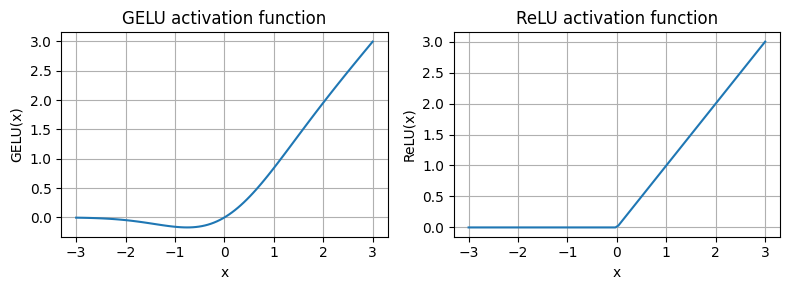

In [17]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

ReLU（右）是一个分段线性函数，当输入为正数时直接输出输入值，否则输出 0。GELU（左）则是一个平滑的非线性函数，它近似 ReLU，但在几乎所有负值（除了在 [上图] 约等于 -0.75的位置外）上都有非零梯度。

- As we can see, ReLU is a piecewise linear function that outputs the input directly if it is positive; otherwise, it outputs zero
- GELU is a smooth, non-linear function that approximates ReLU but with a non-zero gradient for negative values (except at approximately -0.75)

- Next, let's implement the small neural network module, `FeedForward`, that we will be using in the LLM's transformer block later:

我们将使用 GELU 函数来实现小型神经网络模块FeedForward，该模块将在大语言模型的 Transformer 块中使用。

In [18]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        # 初始化父类nn.Module
        super().__init__()
        # 构建Transformer典型的前馈网络结构
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),  # 扩展维度（emb_dim -> 4*emb_dim）
            GELU(),  # 使用GELU激活函数（比ReLU更平滑）
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),  # 恢复维度（4*emb_dim -> emb_dim）
        )
    def forward(self, x):
        return self.layers(x)

In [19]:
print(GPT_CONFIG_124M["emb_dim"])

768


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/09.webp?12" width="400px">

我们将创建一个词元嵌入维度为 768的新 FeedForward 模块，然后将一个包含两个样本且每个样本有 3 个词元的批次输入提供给它：

In [20]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768) 
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


FeedForward 模块在提升模型学习和泛化能力方面非常关键。虽然该模块的输入和输出维度保持一致，但它通过第一个线性层将嵌入维度扩展到了更高的维度，如图4-10所示。扩展之后，应用非线性 GELU 激活函数，然后通过第二个线性变换将维度缩回原始大小。这种设计允许模型探索更丰富的表示空间

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/10.webp" width="400px">

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/11.webp" width="400px">

## 4.4 Adding shortcut connections

- Next, let's talk about the concept behind shortcut connections, also called skip or residual connections
- Originally, shortcut connections were proposed in deep networks for computer vision (residual networks) to mitigate vanishing gradient problems
- A shortcut connection creates an alternative shorter path for the gradient to flow through the network
- This is achieved by adding the output of one layer to the output of a later layer, usually skipping one or more layers in between
- Let's illustrate this idea with a small example network:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/12.webp?123" width="400px">

- In code, it looks like this:

- 用于演示快捷连接的神经网络

In [21]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

- Let's print the gradient values first **without** shortcut connections:

In [22]:
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


- Next, let's print the gradient values **with** shortcut connections:

In [23]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


- As we can see based on the output above, shortcut connections prevent the gradients from vanishing in the early layers (towards `layer.0`)
- We will use this concept of a shortcut connection next when we implement a transformer block

## 4.5 Connecting attention and linear layers in a transformer block

- In this section, we now combine the previous concepts into a so-called transformer block
- A transformer block combines the causal multi-head attention module from the previous chapter with the linear layers, the feed forward neural network we implemented in an earlier section
- In addition, the transformer block also uses dropout and shortcut connections

In [25]:
# If the `previous_chapters.py` file is not available locally,
# you can import it from the `llms-from-scratch` PyPI package.
# For details, see: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# E.g.,
# from llms_from_scratch.ch03 import MultiHeadAttention

from previous_chapters import MultiHeadAttention


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        # 初始化父类nn.Module
        super().__init__()
        # 多头注意力机制模块
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],          # 输入特征维度
            d_out=cfg["emb_dim"],         # 输出特征维度（保持相同）
            context_length=cfg["context_length"],  # 最大上下文长度
            num_heads=cfg["n_heads"],     # 注意力头数
            dropout=cfg["drop_rate"],     # 注意力机制的dropout比例
            qkv_bias=cfg["qkv_bias"])     # 是否在QKV变换中添加偏置
        
        # 前馈神经网络模块（包含维度缩放和激活）
        self.ff = FeedForward(cfg)
        
        # 两个层归一化模块（分别用于注意力和前馈网络）
        self.norm1 = LayerNorm(cfg["emb_dim"])  # 注意力后的归一化
        self.norm2 = LayerNorm(cfg["emb_dim"])  # 前馈后的归一化
        
        # 残差连接时的dropout层（增强模型鲁棒性）
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    
    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x  # 保存原始输入用于残差连接
        x = self.norm1(x)  # Pre-LN结构：先归一化再做注意力
        x = self.att(x)  # 多头注意力计算 [batch_size, seq_len, emb_dim]
        x = self.drop_shortcut(x)  # 对注意力输出做dropout
        x = x + shortcut  # 残差连接（保留原始信息）

        # Shortcut connection for feed forward block
        shortcut = x  # 保存当前状态用于二次残差
        x = self.norm2(x)  # 第二次层归一化
        x = self.ff(x)  # 前馈神经网络处理
        x = self.drop_shortcut(x)  # 对前馈输出做dropout
        x = x + shortcut  # 最终残差连接

        return x  # 输出形状保持[batch_size, seq_len, emb_dim]
    
    

- 这段代码定义了一个 TransformerBlock 类，该类在 PyTorch中实现了一个多头注意力机制(MultiHeadAttention)和一个前馈神经网络(FeedForward)，两者都根据提供的配置字典（cfg，比如 GPT_CONFIG_124M）进行配置。

- 层归一化(LayerNorm)应用于这两个组件之前，而 dropout 应用于这两个组件之后，以便对模型进行正则化并防止过拟合。这种方法也被称为前层归一化(Pre-LayerNorm)。较早的架构（如最初的 Transformer 模型）在自注意力和前馈神经网络之后才应用层归一化，这种方法被称为后层归一化(Post-LayerNorm)，这通常会导致较差的训练效果。

- TransformerBlock 类还实现了前向传播，其中每个组件后面都跟着一个快捷连接，将块的输入加到其输出上。这个关键特性有助于在训练过程中使梯度在网络中流动，并改善深度模型的学习效果（参见 4.4 节）​。

- 使用我们之前定义的 GPT_CONFIG_124M 配置字典来实例化一个 Transformer 块，并输入一些测试数据：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/13.webp?1" width="400px">

Transformer 块示意图。输入的词元被嵌入到 768 维的向量中。每一行对应一个词元的向量表示。Transformer 块的输出是与输入具有相同维度的向量，这些向量可以传递到大语言模型的后续层中

- Suppose we have 2 input samples with 6 tokens each, where each token is a 768-dimensional embedding vector; then this transformer block applies self-attention, followed by linear layers, to produce an output of similar size
- You can think of the output as an augmented version of the context vectors we discussed in the previous chapter

使用我们之前定义的 GPT_CONFIG_124M 配置字典来实例化一个 Transformer 块，并输入一些测试数据

In [26]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/14.webp?1" width="400px">

## 4.6 Coding the GPT model

- We are almost there: now let's plug in the transformer block into the architecture we coded at the very beginning of this chapter so that we obtain a usable GPT architecture
- Note that the transformer block is repeated multiple times; in the case of the smallest 124M GPT-2 model, we repeat it 12 times:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/15.webp" width="400px">

- The corresponding code implementation, where `cfg["n_layers"] = 12`:

In [27]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        # 初始化父类nn.Module
        super().__init__()
        # token嵌入层（将词汇索引映射为稠密向量）
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        # 位置嵌入层（为每个位置生成编码向量） 
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        # 嵌入层后的dropout（正则化防止过拟合）
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # 堆叠多个Transformer块（数量由n_layers配置决定）
        self.trf_blocks = nn.Sequential(
            #* 运算符将列表解包为独立参数，传递给 nn.Sequential 容器。这相当于手动写出：
            #nn.Sequential(TransformerBlock(cfg), TransformerBlock(cfg), ..., TransformerBlock(cfg))
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # 最终层归一化（输出前的标准化处理）
        self.final_norm = LayerNorm(cfg["emb_dim"])
        # 输出投影头（将特征维度映射回词汇表大小）
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False  # 遵循原始Transformer的无偏置设计
        )

    def forward(self, in_idx):
        # 输入形状: [batch_size, seq_len]
        batch_size, seq_len = in_idx.shape
        # 获取token嵌入（形状: [batch_size, seq_len, emb_dim]）
        tok_embeds = self.tok_emb(in_idx)
        # 生成位置编码（0到seq_len-1的连续位置）
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        # 合并token嵌入和位置编码
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        # 应用嵌入层后的dropout
        x = self.drop_emb(x)
        # 通过所有Transformer块处理
        x = self.trf_blocks(x)  # 形状保持[batch_size, seq_len, emb_dim]
        # 最终层归一化
        x = self.final_norm(x)
        # 生成输出logits（形状: [batch_size, seq_len, vocab_size]）
        logits = self.out_head(x)
        return logits



- Using the configuration of the 124M parameter model, we can now instantiate this GPT model with random initial weights as follows:

- 现在，使用传入了cfg 参数的 GPT_CONFIG_124M 字典初始化参数量为 1.24 亿的 GPT 模型，并向其输入我们之前创建的批次文本数据：

In [28]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


- We will train this model in the next chapter
- However, a quick note about its size: we previously referred to it as a 124M parameter model; we can double check this number as follows:

- 在继续编写将模型输出转换为文本的函数之前，让我们花一些时间了解一下模型架构及其规模。通过numel()（​“number of elements”的缩写）方法可以统计模型参数张量的总参数量：

In [29]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


- As we see above, this model has 163M, not 124M parameters; why?
- In the original GPT-2 paper, the researchers applied weight tying, which means that they reused the token embedding layer (`tok_emb`) as the output layer, which means setting `self.out_head.weight = self.tok_emb.weight`
- The token embedding layer projects the 50,257-dimensional one-hot encoded input tokens to a 768-dimensional embedding representation
- The output layer projects 768-dimensional embeddings back into a 50,257-dimensional representation so that we can convert these back into words (more about that in the next section)
- So, the embedding and output layer have the same number of weight parameters, as we can see based on the shape of their weight matrices
- However, a quick note about its size: we previously referred to it as a 124M parameter model; we can double check this number as follows:

In [30]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


- In the original GPT-2 paper, the researchers reused the token embedding matrix as an output matrix
- Correspondingly, if we subtracted the number of parameters of the output layer, we'd get a 124M parameter model:

In [31]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


- In practice, I found it easier to train the model without weight-tying, which is why we didn't implement it here
- However, we will revisit and apply this weight-tying idea later when we load the pretrained weights in chapter 5
- Lastly, we can compute the memory requirements of the model as follows, which can be a helpful reference point:

- 计算前馈模块和注意力模块所包含的参数量，并进行对比。最后，计算一下 GPTModel 对象中 1.63 亿个参数的内存需求：

In [32]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


- Exercise: you can try the following other configurations, which are referenced in the [GPT-2 paper](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=dOad5HoAAAAJ&citation_for_view=dOad5HoAAAAJ:YsMSGLbcyi4C), as well.

    - **GPT2-small** (the 124M configuration we already implemented):
        - "emb_dim" = 768
        - "n_layers" = 12
        - "n_heads" = 12

    - **GPT2-medium:**
        - "emb_dim" = 1024
        - "n_layers" = 24
        - "n_heads" = 16
    
    - **GPT2-large:**
        - "emb_dim" = 1280
        - "n_layers" = 36
        - "n_heads" = 20
    
    - **GPT2-XL:**
        - "emb_dim" = 1600
        - "n_layers" = 48
        - "n_heads" = 25

## 4.7 Generating text

- LLMs like the GPT model we implemented above are used to generate one word at a time

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/16.webp" width="400px">

- The following `generate_text_simple` function implements greedy decoding, which is a simple and fast method to generate text
- In greedy decoding, at each step, the model chooses the word (or token) with the highest probability as its next output (the highest logit corresponds to the highest probability, so we technically wouldn't even have to compute the softmax function explicitly)
- In the next chapter, we will implement a more advanced `generate_text` function
- The figure below depicts how the GPT model, given an input context, generates the next word token

大语言模型逐步生成文本的过程，每次生成一个词元。从初始输入上下文(“Hello, I am”)开始，模型在每轮迭代中预测下一个词元，并将其添加到输入上下文中以进行下一轮预测。如图所示，第一轮迭代添加了“a”​，第二轮迭代添加了“model”​，第三轮迭代添加了“ready”​，逐步形成了完整的句子

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/17.webp" width="600px">

- 图4-17中展示的下一词元生成过程说明了GPT 模型如何在给定输入的情况下生成下一个词元。在每一步中，模型输出一个矩阵，其中的向量表示有可能的下一个词元。将与下一个词元对应的向量提取出来，并通过softmax 函数转换为概率分布。在包含这些概率分数的向量中，找到最高值的索引，这个索引对应于词元 ID。然后将这个词元 ID 解码为文本，生成序列中的下一个词元。最后，将这个词元附加到之前的输入中，形成新的输入序列，供下一次迭代使用。这个逐步的过程使得模型能够按顺序生成文本，从最初的输入上下文中构建连贯的短语和句子。

In [33]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    # 自回归文本生成循环（每次生成1个token）
    for _ in range(max_new_tokens):
        
        # 裁剪上下文至模型支持的长度（滑动窗口机制）
        idx_cond = idx[:, -context_size:]  # 形状保持 [batch_size, context_size]
        
        # 模型前向计算（禁用梯度以节省内存）
        with torch.no_grad():
            logits = model(idx_cond)  # 输出形状 [batch_size, context_size, vocab_size]
        
        # 聚焦最后一个token的预测结果（只需最新预测）
        logits = logits[:, -1, :]  # 形状变为 [batch_size, vocab_size]

        # 将logits转换为概率分布（温度参数为1的softmax）
        probas = torch.softmax(logits, dim=-1)

        # 贪婪采样：选择概率最高的token（无随机性）
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # 保持维度便于拼接

        # 扩展生成序列（自回归的核心操作）
        idx = torch.cat((idx, idx_next), dim=1)  # 形状更新为 [batch_size, n_tokens+1]

    return idx  # 返回最终生成的token索引序列



- The `generate_text_simple` above implements an iterative process, where it creates one token at a time

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/18.webp" width="600px">

- Let's prepare an input example:

In [34]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [35]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


- Remove batch dimension and convert back into text:

- 使用分词器的 .decode 方法可以将 ID 转换回文本：

In [36]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


- Note that the model is untrained; hence the random output texts above
- We will train the model in the next chapter

## Summary and takeaways

- See the [./gpt.py](./gpt.py) script, a self-contained script containing the GPT model we implement in this Jupyter notebook
- You can find the exercise solutions in [./exercise-solutions.ipynb](./exercise-solutions.ipynb)